In [48]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
ee.Initialize()

# Define init params - area, satellite, years

In [92]:
# Area over which to aggregate data
area = (ee.FeatureCollection('ft:1fRY18cjsHzDgGiJiS2nnpUU3v9JPDc2HNaR7Xk8')
      .filter(ee.Filter().eq('Name', 'California')))

# Use this to change to the county level. 
# area = (ee.FeatureCollection('ft:1FEPBzXYqUbdWXG2wTFOyb-ts9_GbeI5NFraMq2yk')
#       .filter(ee.Filter().eq('COUNTY num', 95)))

# import the RS products
trmm = ee.ImageCollection('TRMM/3B42')

# Set the time range
years = [x for x in range(2000, 2016)]

### Helpers 

In [4]:
def filter_date_chirps(product,year):
    startyear = ee.Date.fromYMD(year,1,1)
    endyear =ee.Date.fromYMD(year+1,12,31)
    prod = product.filterDate(startyear, endyear).sort('system:time_start', False).select("precipitation")
    return prod
    
def filter_date_modis(product,year):
    startyear = ee.Date.fromYMD(year,1,1)
    endyear =ee.Date.fromYMD(year+1,12,31)
    prod = product.filterDate(startyear, endyear).sort('system:time_start', False).select("NDVI")
    return prod

def aggregate(product,year):

    # Filter
    filtered = filter_date_modis(product, year)

    # calculate the monthly mean
    def calcMean(imageCollection,year):
        mylist = ee.List([])
        months = range(2,9)
        for m in months:
                w = imageCollection.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).sum();
                mylist = mylist.add(w.set('year', year).set('month', m).set('date', ee.Date.fromYMD(year,m,1)).set('system:time_start',ee.Date.fromYMD(year,m,1)))
        return ee.ImageCollection.fromImages(mylist)

    # run the calcMonthlyMean function
    seasonal = ee.ImageCollection(calcMean(filtered, year))

    # select the region of interest, 500 is the cellsize in meters
    seasonal = seasonal.getRegion(area,500,"epsg:4326").getInfo()

    return seasonal 

def aggregate_precip(product,year):

    # Filter
    filtered = filter_date_chirps(product, year)

    # calculate the monthly mean
    def calcMean(imageCollection,year):
        mylist = ee.List([])
        months = range(1,12)
        for m in months:
                w = imageCollection.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).sum();
                mylist = mylist.add(w.set('year', year).set('month', m).set('date', ee.Date.fromYMD(year,m,1)).set('system:time_start',ee.Date.fromYMD(year,m,1)))
        return ee.ImageCollection.fromImages(mylist)

    # run the calcMonthlyMean function
    seasonal = ee.ImageCollection(calcMean(filtered, year))

    # select the region of interest, 25000 is the cellsize in meters
    seasonal = seasonal.getRegion(area,25000,"epsg:4326").getInfo()

    return seasonal 

def make_df_from_imcol(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df.NDVI)
    
    return lons, lats, data
    return df

def df_from_ee_object(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    return(df)

# Main routine

In [5]:
finals = []
for year in years:
    finals.append(aggregate_precip(trmm,year))

In [16]:
len(finals[0])

9384

In [6]:
dfs = []
for i in finals:
    dfs.append(df_from_ee_object(i))

Now, you have the annual sums in a dataframe with lat, lon, precip

# Visualize the sums

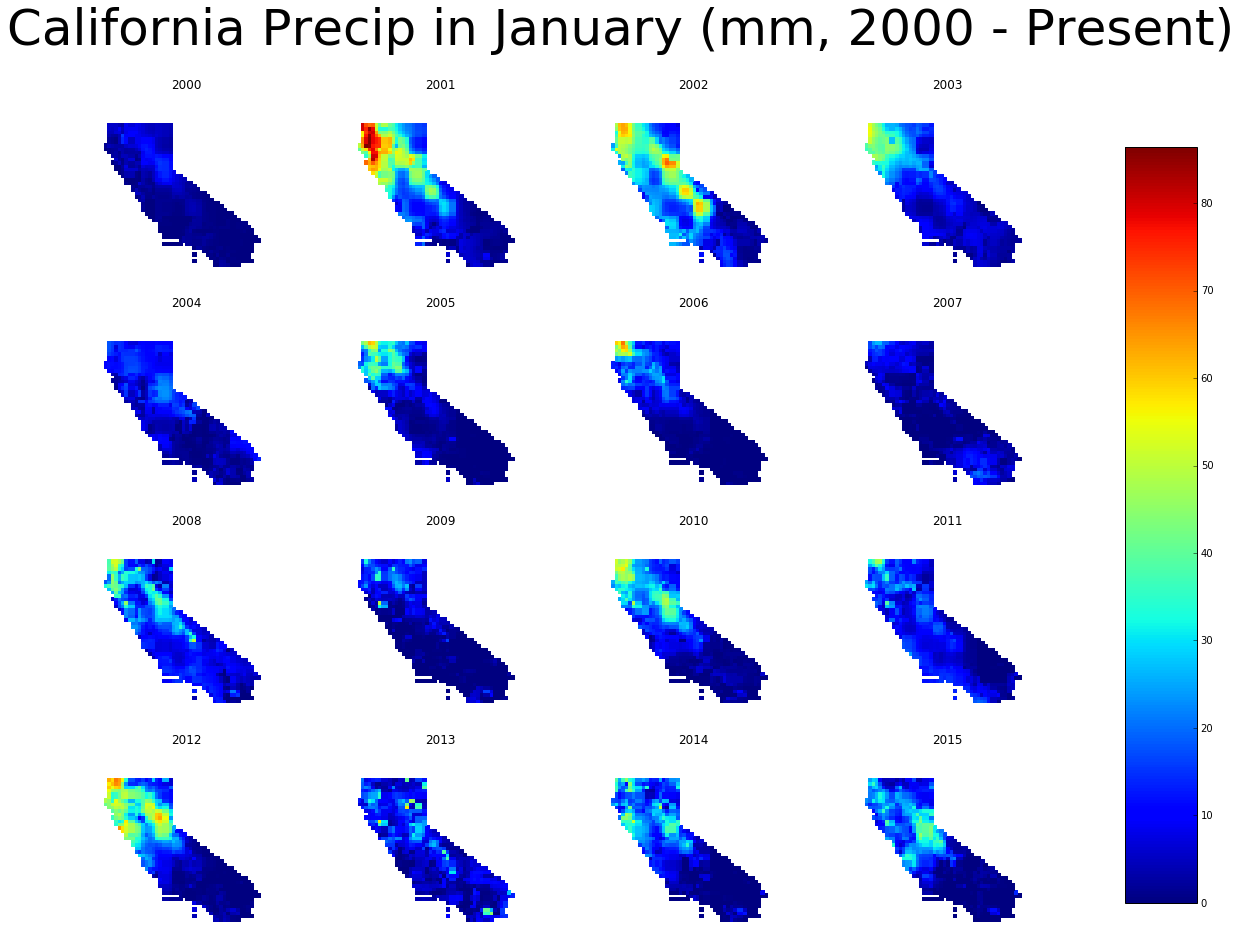

In [18]:
fig, axs = plt.subplots(4,4, figsize=(20,15))
axs = axs.ravel()

plt.suptitle('California Precip in January (mm, 2000 - Present)', size = 50)

for i in range(len(dfs)):
    
    a = axs[i].scatter(dfs[i]['longitude'],dfs[i]['latitude'],marker = "s",c = dfs[i]['precipitation'],s= 20, lw = 0)
    axs[i].set_title(2000+i)
    axs[i].axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(a, cax=cbar_ax)

plt.show()

In [17]:
len(dfs[0])

id longitude latitude                                        time  \
1      0  -117.118  32.6762  {u'type': u'Date', u'value': 946684800000}   
2      1  -117.118  32.6762  {u'type': u'Date', u'value': 949363200000}   
3      2  -117.118  32.6762  {u'type': u'Date', u'value': 951868800000}   
4      3  -117.118  32.6762  {u'type': u'Date', u'value': 954547200000}   
5      4  -117.118  32.6762  {u'type': u'Date', u'value': 957139200000}   
6      5  -117.118  32.6762  {u'type': u'Date', u'value': 959817600000}   
7      6  -117.118  32.6762  {u'type': u'Date', u'value': 962409600000}   
8      7  -117.118  32.6762  {u'type': u'Date', u'value': 965088000000}   
9      8  -117.118  32.6762  {u'type': u'Date', u'value': 967766400000}   
10     9  -117.118  32.6762  {u'type': u'Date', u'value': 970358400000}   
11    10  -117.118  32.6762  {u'type': u'Date', u'value': 973036800000}   
12     0  -116.893  32.6762  {u'type': u'Date', u'value': 946684800000}   
13     1  -116.893  32.6762  {u'type': u'Date', u'value': 949363200000}   
14     2  -116.893  32.6762  {u'type': u'Date', u'value': 951868800000}   
15     3  -116.893  32.6762  {u'type': u'Date', u'value': 954547200000}   
16     4  -116.893  32.6762  {u'type': u'Date', u'value': 957139200000}   
17     5  -116.893  32.6762  {u'type': u'Date', u'value': 959817600000}   
18     6  -116.893  32.6762  {u'type': u'Date', u'value': 962409600000}   
19     7  -116.893  32.6762  {u'type': u'Date', u'value': 965088000000}   
20     8  -116.893  32.6762  {u'type': u'Date', u'value': 967766400000}   
21     9  -116.893  32.6762  {u'type': u'Date', u'value': 970358400000}   
22    10  -116.893  32.6762  {u'type': u'Date', u'value': 973036800000}   
23     0  -116.669  32.6762  {u'type': u'Date', u'value': 946684800000}   
24     1  -116.669  32.6762  {u'type': u'Date', u'value': 949363200000}   
25     2  -116.669  32.6762  {u'type': u'Date', u'value': 951868800000}   
26     3  -116.669  32.6762  {u'type': u'Date', u'value': 954547200000}   
27     4  -116.669  32.6762  {u'type': u'Date', u'value': 957139200000}   
28     5  -116.669  32.6762  {u'type': u'Date', u'value': 959817600000}   
29     6  -116.669  32.6762  {u'type': u'Date', u'value': 962409600000}   
30     7  -116.669  32.6762  {u'type': u'Date', u'value': 965088000000}   
...   ..       ...      ...                                         ...   
9354   3  -120.487   41.884  {u'type': u'Date', u'value': 954547200000}   
9355   4  -120.487   41.884  {u'type': u'Date', u'value': 957139200000}   
9356   5  -120.487   41.884  {u'type': u'Date', u'value': 959817600000}   
9357   6  -120.487   41.884  {u'type': u'Date', u'value': 962409600000}   
9358   7  -120.487   41.884  {u'type': u'Date', u'value': 965088000000}   
9359   8  -120.487   41.884  {u'type': u'Date', u'value': 967766400000}   
9360   9  -120.487   41.884  {u'type': u'Date', u'value': 970358400000}   
9361  10  -120.487   41.884  {u'type': u'Date', u'value': 973036800000}   
9362   0  -120.262   41.884  {u'type': u'Date', u'value': 946684800000}   
9363   1  -120.262   41.884  {u'type': u'Date', u'value': 949363200000}   
9364   2  -120.262   41.884  {u'type': u'Date', u'value': 951868800000}   
9365   3  -120.262   41.884  {u'type': u'Date', u'value': 954547200000}   
9366   4  -120.262   41.884  {u'type': u'Date', u'value': 957139200000}   
9367   5  -120.262   41.884  {u'type': u'Date', u'value': 959817600000}   
9368   6  -120.262   41.884  {u'type': u'Date', u'value': 962409600000}   
9369   7  -120.262   41.884  {u'type': u'Date', u'value': 965088000000}   
9370   8  -120.262   41.884  {u'type': u'Date', u'value': 967766400000}   
9371   9  -120.262   41.884  {u'type': u'Date', u'value': 970358400000}   
9372  10  -120.262   41.884  {u'type': u'Date', u'value': 973036800000}   
9373   0  -120.037   41.884  {u'type': u'Date', u'value': 946684800000}   
9374   1  -120.037   41.884  {u'type': u'Date', u'value': 949363200000}   
9375   2  -120.037   41.884  {u

# Write to csv

In [ ]:
dfs_by_year = dict(zip(years,dfs))
for k,v in dfs_by_year.items():
    path = os.path.join(os.getcwd(), "trmm_csvs")
    v.to_csv(os.path.join(path,str(k)+"_.csv"))